In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import timedelta

# Nakhon Pathom Data

(28678, 5)

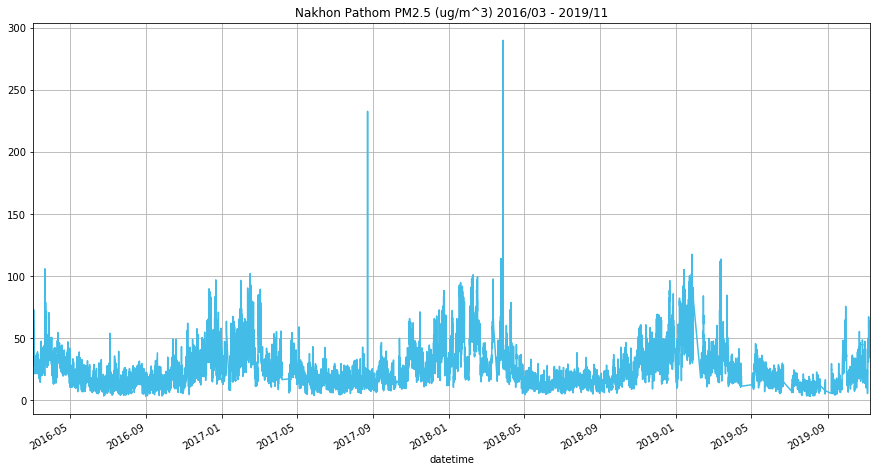

In [3]:
df = pd.read_csv('Nakhon_Pathom_PM25.csv')
df.rename(columns={'UTC Hour':'Hour'}, inplace=True)
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]) + pd.Timedelta(hours=7) # UTC to Bangkok time
df.index = df['datetime']
df.Hour = df.index.hour # UTC hour to UTC+7
df.drop(columns=['PM10_mask','Retrospective','datetime'],inplace=True)
df['PM2.5'].plot(figsize=(15,8),title="Nakhon Pathom PM2.5 (ug/m^3) 2016/03 - 2019/11", color='#44BCE8', grid=True)
df.shape

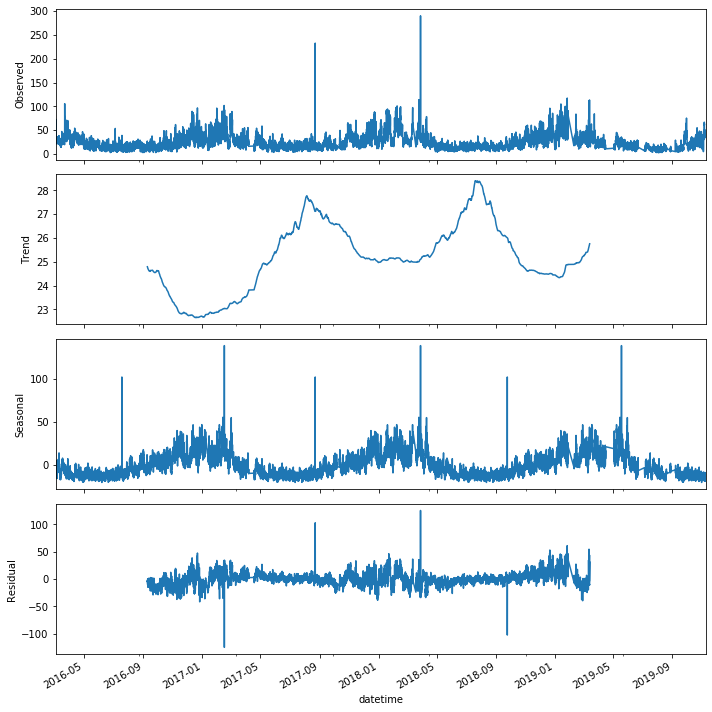

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
result = seasonal_decompose(df['PM2.5'], model='addtive', freq=365*24)
fig = result.plot()
plt.show()

# Feature

In [5]:
# Date features
df['dayofweek'] = df.index.dayofweek 
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.weekofyear
df['quarter'] = df.index.quarter
#df['Last24hrs_mean'] = df['PM2.5'].rolling(24).mean().shift(24)
# add holiday?
df.nlargest(5, 'PM2.5') # top 5 highest pm2.5

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter
datetime,,,,,,,,,
2018-03-28 17:00:00,2018,3,28,17,289.8,2,87,13,1
2018-03-28 16:00:00,2018,3,28,16,288.2,2,87,13,1
2017-08-22 19:00:00,2017,8,22,19,232.6,1,234,34,3
2019-01-26 09:00:00,2019,1,26,9,117.4,5,26,4,1
2019-01-26 06:00:00,2019,1,25,6,116.3,5,26,4,1


In [6]:
df.nsmallest(5, 'PM2.5')

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter
datetime,,,,,,,,,
2019-08-04 07:00:00,2019,8,4,7,2.9,6,216,31,3
2016-08-31 05:00:00,2016,8,30,5,3.1,2,244,35,3
2016-06-24 21:00:00,2016,6,24,21,3.2,4,176,25,2
2016-09-26 18:00:00,2016,9,26,18,3.2,0,270,39,3
2019-07-29 20:00:00,2019,7,29,20,3.2,0,210,31,3


In [7]:
## Lag data (previous hours)
def add_Lag(df, lags):
    for i in lags:
        df[f'lag_{i}'] = df['PM2.5'].shift(i)
    return df
#df = add_Lag(df, [1]) # [24,48,72,96,120,144,168] , range(1,25)

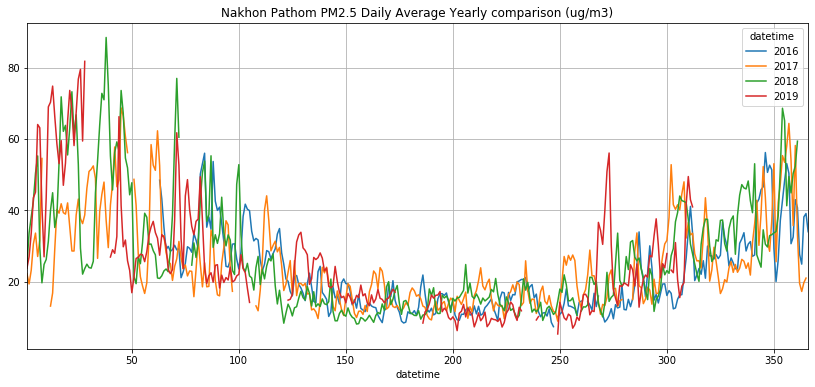

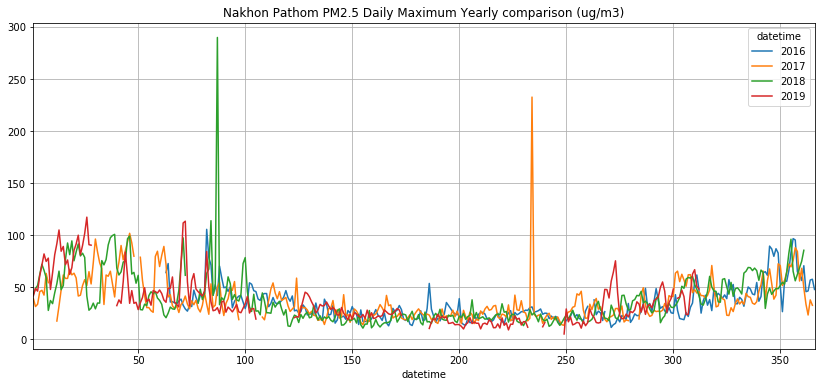

In [8]:
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='PM2.5', aggfunc='mean')
pv.plot(title="Nakhon Pathom PM2.5 Daily Average Yearly comparison (ug/m3)",figsize=(14,6), grid=True)
pv2 = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='PM2.5', aggfunc='max')
pv2.plot(title="Nakhon Pathom PM2.5 Daily Maximum Yearly comparison (ug/m3)",figsize=(14,6), grid=True)

Text(0.5, 15.0, 'dayofweek (Mon=1, Sun=7)')

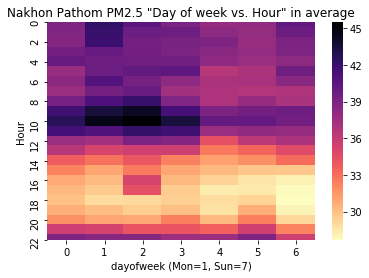

In [9]:
peak_months = df.loc[(df['Month'] == 12) | (df['Month'] <= 4)]
fig, ax = plt.subplots(figsize=(6,4)) 
hrvsday = peak_months.pivot_table(values='PM2.5',index='Hour',columns='dayofweek',aggfunc='mean')
ax.set_title('Nakhon Pathom PM2.5 "Day of week vs. Hour" in average')
sns.heatmap(hrvsday,cmap='magma_r', ax=ax) #  Monday=0, Sunday=6
ax.set_xlabel('dayofweek (Mon=1, Sun=7)')

## Check Data type

In [10]:
# weather features
weather = pd.read_csv('salaya_weather.csv', parse_dates=[0], index_col=[0],low_memory=False)
weather = weather.iloc[:,:14] # drop unused col
weather = weather.drop(columns=['windchill'])
weather = pd.get_dummies(weather, prefix=['wind_dir']) # wind direction string to catagory columns
weather.dtypes

FileNotFoundError: [Errno 2] File b'salaya_weather.csv' does not exist: b'salaya_weather.csv'

In [ ]:
# average multiple row in 1 hour to 1 row 1 hour, set as index
weather_dt = pd.to_datetime(weather.index)
weather_hrly = weather.groupby([weather_dt.date, weather_dt.hour]).mean()
weather_hrly = weather_hrly.reset_index()
weather_hrly['level_0'] = weather_hrly['level_0'].apply(lambda x: x.strftime('%Y-%m-%d'))
weather_hrly['date'] = weather_hrly['date'].apply(lambda x: '{0:0>2}'.format(x))
weather_hrly.index = pd.to_datetime(weather_hrly['level_0'] + ' ' + weather_hrly['date'].apply(str), format='%Y-%m-%d %H')
weather_hrly = weather_hrly.drop(columns=['level_0','date'])
#weather_hrly = weather_hrly.fillna(weather_hrly.mean()) # fill nan with mean of column
weather_hrly.head(5)

In [ ]:
## merge pm2.5 with weather
df_merged = pd.concat([df, weather_hrly], axis=1, join_axes=[df.index])
#df_merged.columns.values
df_merged.shape

In [ ]:
# Linear correlation
df_test = df_merged.drop(df.filter(regex='lag').columns, axis=1)

# calculate the correlation matrix
corr = df_test.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap='magma_r',
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)

print(corr['PM2.5'].sort_values(ascending=False)[:10])
print(corr['PM2.5'].sort_values(ascending=True)[:10])

In [ ]:
df_merged.dayofweek = df_merged.dayofweek.apply(str)
df_merged = pd.get_dummies(df_merged, prefix=['dayofweek'])

# Train Data / Test Data

In [ ]:
train_percent = 0.7
train = df_merged.iloc[:int(len(df_merged)*train_percent)]
test = df_merged.iloc[int(len(df_merged)*train_percent):]
X_train = train.drop(columns=['PM2.5'])
X_test = test.drop(columns=['PM2.5'])
y_train = train['PM2.5']
y_test = test['PM2.5']

In [ ]:
y_test[y_test.isnull()]

In [ ]:
plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
plt.plot(y_train.index, y_train)
plt.plot(y_test.index, y_test)
plt.show()

# Train Data model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

In [ ]:
xgb.plot_importance(reg, height=0.7, max_num_features=20)

In [ ]:
X_test_pred = reg.predict(X_test)

# Plot test data vs. prediction data
plt.figure(figsize=(20,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
selectdate = 365*24
plt.plot(y_test.index[selectdate:], X_test_pred[selectdate:], label='Predict')
plt.plot(y_test.index[selectdate:], y_test[selectdate:], alpha=0.6, label='Observe')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(20,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
plt.plot(y_test.index, X_test_pred, label='Predict')
plt.plot(y_test.index, y_test, alpha=0.6, label='Observe')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Check accuracy
from sklearn.metrics import r2_score
print("Model accuracy: MSE/R-square:")
print(mean_squared_error(y_test, X_test_pred), r2_score(y_test, X_test_pred))
print()

## Use mean-value to predict
print("Mean-value model accuracy: MSE/R-square:")
mean_value = np.mean(y_test)
print(mean_squared_error(y_test, np.ones(len(y_test))*mean_value), r2_score(y_test, np.ones(len(y_test))))

# print()
# ## Use lag-1 predict
# print("Lag-1 model accuracy: MSE/R-square:")
# mean_squared_error(y_test, X_test['lag_1'].values), r2_score(y_test, X_test['lag_1'].values)
## Lag-1 model accuracy: MSE/R-square:
## (10.082567586694974, 0.9482315368050865)

# Model Expaination - Plot Data

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(reg)
X = df_merged.drop(columns=['PM2.5'])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap.dependence_plot("dayofyear", shap_values, X)
shap.dependence_plot("Hour", shap_values, X)
shap.dependence_plot("Day", shap_values, X)
shap.dependence_plot("dewpoint", shap_values, X)
shap.dependence_plot("wind_gust_speed", shap_values, X)
shap.dependence_plot("pressure", shap_values, X)
shap.dependence_plot("humidity", shap_values, X)
shap.dependence_plot("heatindex", shap_values, X)
shap.dependence_plot("temperature", shap_values, X)
shap.dependence_plot("wind_dir_degrees", shap_values, X)
shap.dependence_plot("precip_today", shap_values, X)

In [ ]:
shap_interaction_values = shap.TreeExplainer(reg).shap_interaction_values(X.iloc[-639:,:])
shap.summary_plot(shap_interaction_values, X.iloc[-639:,:])

In [ ]:
# visualize n day prediction explanation
selectdate = '2018-11-25 09:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [ ]:
selectdate = '2018-12-24 10:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [ ]:
df.nsmallest(5, 'PM2.5')
selectdate = '2018-12-31 22:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [ ]:
selectdate = '2019-01-10 08:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [ ]:
selectdate = '2019-11-8 08:00:00'
row = X.index.get_loc(selectdate)
row += 6 # For accurate data
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])